In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from matplotlib.patheffects import withStroke
from matplotlib.patches import FancyBboxPatch

plt.rcParams.update({
"font.size": 16,
"text.usetex": False,
"mathtext.fontset": "stixsans"
})

In [89]:
import numpy as np

def score(pt, D1, D2, gp):
    factor = D1 - D2
    return (10 ** (D1 / 10)) / (1 + 10 ** ((factor / 2 - pt - 2 * gp) / 10))

def points_match(x):
    if x > 0:
        return 1
    elif x < 0:
        return -5
    elif x == 0:
        return -2

class world_cup:

    def __init__(self, groups, squad_distributions, temperature=0):
        self.groups = groups
        self.squad_distributions = squad_distributions
        self.temperature = temperature  # Temperature attribute
        self.winners = []
        self.champion = None
        self.all_pairs = []
        self.validate_inputs()

    def validate_inputs(self):
        """Ensure all teams in groups have valid distributions."""
        all_teams = [team for group in self.groups.values() for team in group]
        missing_teams = [team for team in all_teams if team not in self.squad_distributions]
        if missing_teams:
            raise ValueError(f"The following teams are missing from squad_distributions: {missing_teams}")

    def simulate_match(distA, distB, teamA, teamB, temperature=0):
        """Simulate a single match considering temperature."""
        scoreA = distA.resample(1)
        scoreB = distB.resample(1)

        # Adding a small temperature-based randomness
        scoreA += np.random.normal(0, temperature * 0.1)  
        scoreB += np.random.normal(0, temperature * 0.1)

        delta = scoreA - scoreB
        if delta < 0.9 and delta > -0.9:
            return "draw"
        elif delta >= 0.9:
            return teamA
        else:
            return teamB

    def __ponctuation(self, team, match_result):
        """Assign points based on match results."""
        if team == match_result:
            return 3
        elif match_result == "draw":
            return 1
        else:
            return 0

    def simulate_group_stage(self):
        """Simulate all matches in the group stage considering temperature."""
        group_results = {g: [] for g in self.groups}
        points = {}

        for group in self.groups:
            teams = self.groups[group]
            points[group] = {team: 0 for team in teams}

            for i in range(len(teams)):
                teamA = teams[i]
                for j in range(i + 1, len(teams)):
                    teamB = teams[j]
                    distA = self.squad_distributions[teamA]
                    distB = self.squad_distributions[teamB]
                    match_result = world_cup.simulate_match(distA, distB, teamA, teamB, temperature=self.temperature)
                    group_results[group].append([teamA, teamB, match_result])

                    points[group][teamA] += self.__ponctuation(teamA, match_result)
                    points[group][teamB] += self.__ponctuation(teamB, match_result)

        return group_results, points
    
    def __rank_teams(self, points):
        """Rank teams based on points."""
        group_rankings = {}
        for group, group_points in points.items():
            group_rankings[group] = sorted(group_points.items(), key=lambda x: x[1], reverse=True)
        return group_rankings

    def __pair_round_of_16(self, rankings):
        """Pair teams for the Round of 16 based on FIFA rules."""
        # FIFA-defined matchups
        matchups = [
            ("A1", "B2"), ("C1", "D2"), ("E1", "F2"), ("G1", "H2"),
            ("B1", "A2"), ("D1", "C2"), ("F1", "E2"), ("H1", "G2")
        ]

        pairs = []
        group_winners = {group: rankings[group][0][0] for group in rankings}  # First-ranked team
        group_runners_up = {group: rankings[group][1][0] for group in rankings}  # Second-ranked team

        for match in matchups:
            group1, group2 = match[0][:-1], match[1][:-1]  # Extract "A" from "A1", "B" from "B2"
            if group1 in group_winners and group2 in group_runners_up:
                team1 = group_winners[group1]
                team2 = group_runners_up[group2]
                pairs.append((team1, team2))

        return pairs

    def __simulate_knockout_round(self, pairs, print=False):
        """Simulate a knockout round."""
        if print:
            print("Knockout Pairs:", pairs)

        winners = []
        for teamA, teamB in pairs:
            if teamA not in self.squad_distributions or teamB not in self.squad_distributions:
                raise KeyError(f"One of the teams ({teamA}, {teamB}) is not in squad_distributions.")

            distA = self.squad_distributions[teamA]
            distB = self.squad_distributions[teamB]
            match_result = world_cup.simulate_match(distA, distB, teamA, teamB)

            if match_result == "draw":
                # Extra time
                match_result = world_cup.simulate_match(distA, distB, teamA, teamB)
                if match_result == "draw":
                    # Penalty shootout
                    match_result = np.random.choice([teamA, teamB])
            winners.append(match_result)
        return winners

    def simulate_knockout_stage(self, points, plot=True):
        """
        Simulate the entire knockout stage and return pairs and winners for plotting.
        
        :param points: Group stage points to rank teams
        :return: A tuple containing (champion, all_pairs, all_winners)
                - champion: The winning team
                - all_pairs: List of lists containing pairs for each stage
                - all_winners: List of lists containing winners for each stage
        """
        # Rank teams and pair for the Round of 16
        rankings = self.__rank_teams(points)
        round_of_16_pairs = self.__pair_round_of_16(rankings)
        
        all_pairs = [round_of_16_pairs]  # Store pairs for all stages
        all_winners = []  # Store winners for all stages
        
        # Simulate Round of 16
        round_of_16_winners = self.__simulate_knockout_round(round_of_16_pairs)
        all_winners.append(round_of_16_winners)
        
        # Simulate Quarter-Finals
        quarter_final_pairs = [
            (round_of_16_winners[i], round_of_16_winners[i + 1]) 
            for i in range(0, len(round_of_16_winners), 2)
        ]
        all_pairs.append(quarter_final_pairs)
        
        quarter_final_winners = self.__simulate_knockout_round(quarter_final_pairs)
        all_winners.append(quarter_final_winners)
        
        # Simulate Semi-Finals
        semi_final_pairs = [
            (quarter_final_winners[i], quarter_final_winners[i + 1]) 
            for i in range(0, len(quarter_final_winners), 2)
        ]
        all_pairs.append(semi_final_pairs)
        
        semi_final_winners = self.__simulate_knockout_round(semi_final_pairs)
        all_winners.append(semi_final_winners)
        
        # Simulate Final
        final_pair = [(semi_final_winners[0], semi_final_winners[1])]
        all_pairs.append(final_pair)
        
        champion = self.__simulate_knockout_round(final_pair)[0]
        all_winners.append([champion])

        self.all_pairs = all_pairs
        self.champion = champion
        self.winners = all_winners

        if plot:
            self.draw_knockout_bracket()
        
        return champion, all_pairs, all_winners
    

    def draw_knockout_bracket(self):
        """
        Draw a modern, polished knockout bracket diagram with winners centered between their contestants.
        """

        # Create figure with dark background
        plt.style.use('dark_background')
        fig, ax = plt.subplots(figsize=(16, 10))
        fig.patch.set_facecolor('#1a1a2e')
        ax.set_facecolor('#1a1a2e')
        ax.axis('off')

        all_pairs = self.all_pairs
        winners = self.winners
        champion = self.champion

        # Settings
        num_stages = len(all_pairs)
        x_positions = list(range(num_stages + 1))
        max_pairs = max(len(stage) for stage in all_pairs)
        y_spacing = max_pairs * 2.2

        # Color scheme
        COLORS = {
            'background': '#1a1a2e',
            'regular_box': '#16213e',
            'winner_box': '#0f3460',
            'champion_box': '#533483',
            'regular_text': '#e94560',
            'winner_text': '#ffffff',
            'champion_text': '#ffd700',
            'lines': '#e94560',
            'stage_labels': '#e94560'
        }

        # Compute positions
        y_positions = []
        team_positions = {}
        winner_positions = {}  # New dictionary to store winner positions
        
        for i, stage in enumerate(all_pairs):
            stage_y_positions = []
            base_y = (y_spacing - len(stage) * 2.2) / 2
            
            for j in range(len(stage)):
                yA = base_y + j * 2.2
                yB = yA + 1.1
                stage_y_positions.extend([yA, yB])
                
                # Store team positions
                teamA, teamB = all_pairs[i][j]
                team_positions[(teamA, i)] = yA
                team_positions[(teamB, i)] = yB
                
                # Calculate and store winner position for next round
                if i < num_stages - 1:
                    winner = winners[i][j]
                    winner_y = (yA + yB) / 2  # Center between the two teams
                    winner_positions[(winner, i + 1)] = winner_y
            
            y_positions.append(stage_y_positions)
        
        # Update team positions with winner positions
        team_positions.update(winner_positions)
        
        # Special handling for champion
        final_teams = all_pairs[-1][0]
        final_y = (team_positions[(final_teams[0], num_stages-1)] + 
                team_positions[(final_teams[1], num_stages-1)]) / 2
        team_positions[(champion, num_stages)] = final_y

        def draw_team_box(x, y, team, is_winner=False, is_champion=False):
            if is_champion:
                box_color = COLORS['champion_box']
                text_color = COLORS['champion_text']
                fontsize = 14
                box_height = 0.4
                box_width = 0.8
                alpha = 0.9
            elif is_winner:
                box_color = COLORS['winner_box']
                text_color = COLORS['winner_text']
                fontsize = 11
                box_height = 0.35
                box_width = 0.7
                alpha = 0.8
            else:
                box_color = COLORS['regular_box']
                text_color = COLORS['regular_text']
                fontsize = 10
                box_height = 0.3
                box_width = 0.6
                alpha = 0.7

            rect = FancyBboxPatch(
                (x - box_width/2, y - box_height/2),
                box_width, box_height,
                boxstyle=f"round,pad=0.1,rounding_size=0.1",
                facecolor=box_color,
                edgecolor='none',
                alpha=alpha,
                zorder=2
            )
            ax.add_patch(rect)

            text = ax.text(x, y, team,
                        ha='center', va='center',
                        fontsize=fontsize,
                        fontweight='bold',
                        color=text_color,
                        zorder=3)
            
            text.set_path_effects([
                withStroke(linewidth=2, foreground=box_color)
            ])

        def draw_connection_lines(x1, y1, x2, y2):
            mid_x = (x1 + x2) / 2
            ax.plot([x1, mid_x, x2], 
                    [y1, y2, y2],
                    color=COLORS['lines'],
                    alpha=0.4,
                    linewidth=1,
                    zorder=1,
                    linestyle='-')

        # Draw stages
        for stage_idx, stage_pairs in enumerate(all_pairs):
            stage_winners = winners[stage_idx] if stage_idx < len(winners) else []
            
            for pair_idx, (teamA, teamB) in enumerate(stage_pairs):
                yA = team_positions[(teamA, stage_idx)]
                yB = team_positions[(teamB, stage_idx)]
                
                winner = stage_winners[pair_idx] if pair_idx < len(stage_winners) else None
                
                # Draw team boxes
                draw_team_box(x_positions[stage_idx], yA, teamA, teamA == winner)
                draw_team_box(x_positions[stage_idx], yB, teamB, teamB == winner)
                
                # Draw connecting lines
                if stage_idx < num_stages:
                    winner = winners[stage_idx][pair_idx]
                    winner_y = team_positions[(winner, stage_idx + 1)]
                    draw_connection_lines(x_positions[stage_idx], yA, x_positions[stage_idx + 1], winner_y)
                    draw_connection_lines(x_positions[stage_idx], yB, x_positions[stage_idx + 1], winner_y)

        # Draw champion
        draw_team_box(x_positions[-1], team_positions[(champion, num_stages)], champion, is_champion=True)

        # Add stage labels
        stages = ['Round of 16', 'Quarter-Finals', 'Semi-Finals', 'Final', 'Champion']
        for i, stage in enumerate(stages):
            ax.text(i, y_spacing - 0.5, stage,
                    ha='center', va='bottom',
                    fontsize=12,
                    fontweight='bold',
                    color=COLORS['stage_labels'],
                    alpha=0.7)

        plt.title("FIFA World Cup Knockout Stage",
                fontsize=16,
                fontweight='bold',
                color=COLORS['winner_text'],
                pad=20)

        plt.tight_layout()
        plt.show()
        plt.style.use('default')

Scores Table

Each match generates a score for both teams based on the result $r$ (V,E,D), difficulty of winning agains team $D_{team}$ and adversary $D_{adv}$ (based on the FIFA ranking) and goals balance $\Delta g$:
       $$Score = 10^{D_{team}/10}/(1+10^{[(D_{team}-D_{adv})/2 - r - 2\Delta g]/10})$$

In [5]:
D = pd.read_csv("difficulty.csv").astype({"squad":str,"rank":int,"difficulty":float})

regions = ["europe","southamerica","concacaf","africa","asia"]
scores_region, squads = {},{}

for region in regions:
    df = pd.read_csv(f"qualifiers_{region}.csv").dropna().astype({"Team_1":str,"Goals_1":int,"Goals_2":int,"Team_2":str})
    df["gp_1"] = df.apply(lambda row: row.Goals_1 - row.Goals_2, axis=1) 
    df["gp_2"] = df.apply(lambda row: row.Goals_2 - row.Goals_1, axis=1) 

    df["pt_1"] = df["gp_1"].apply(points_match)
    df["pt_2"] = df["gp_2"].apply(points_match)

    df["D_1"] = df["Team_1"].map({x:y for x,y in zip(D["squad"],D["difficulty"])})
    df["D_2"] = df["Team_2"].map({x:y for x,y in zip(D["squad"],D["difficulty"])})
    df.dropna(inplace=True)

    df["scores_1"] = df.apply(lambda row: score(row.pt_1, row.D_1, row.D_2, row.gp_1), axis=1)
    df["scores_2"] = df.apply(lambda row: score(row.pt_2, row.D_2, row.D_1, row.gp_2), axis=1)
    
    squads[region] = pd.unique(df[['Team_1', 'Team_2']].values.ravel('K'))
    scores_region[region] = df
    
scores_region["concacaf"]

,Team_1,Goals_1,Goals_2,Team_2,gp_1,gp_2,pt_1,pt_2,D_1,D_2,scores_1,scores_2
0,Canada,1,1,Honduras,0,0,-2,-2,5.31,3.09,1.114825,0.914522
1,Panama,0,0,Costa Rica,0,0,-2,-2,4.26,5.68,1.136836,1.290227
2,Mexico,2,1,Jamaica,1,-1,1,-5,7.49,4.08,3.220408,0.583547
3,El Salvador,0,0,USA,0,0,-2,-2,3.46,7.26,1.096330,1.540241
4,Jamaica,0,3,Panama,-3,3,-5,1,4.08,4.26,0.191927,2.215543
...,...,...,...,...,...,...,...,...,...,...,...,...
57,Qatar,1,0,Honduras,1,-1,1,-5,4.86,3.09,1.896576,0.400370
58,Qatar,2,0,Guatemala,2,-2,1,-5,4.86,1.23,2.068494,0.213066
59,Guatemala,1,2,Honduras,-1,1,-5,1,1.23,3.09,0.263071,1.256759
60,Guatemala,4,0,El Salvador,4,-4,1,-5,1.23,3.46,1.209596,0.082790


# Score Distribution

Based on the score's table, we assemble a score distribution using a gaussian kernel density estimator.

In [6]:
score_dens = {}
scores_squad = {}
squad_distribution = {} 

for region in regions:

    for squad in squads[region]:
        home = scores_region[region][scores_region[region]["Team_1"] == squad]["scores_1"]
        away = scores_region[region][scores_region[region]["Team_2"] == squad]["scores_2"]
        scores_squad[squad] = pd.concat([home,away])
        squad_distribution[squad] = stats.gaussian_kde(scores_squad[squad],bw_method=0.5)

# Matches

To simulate a match, scores are sampled from distributions. The highest score wins and if the difference of scores is below 1, it's a draw

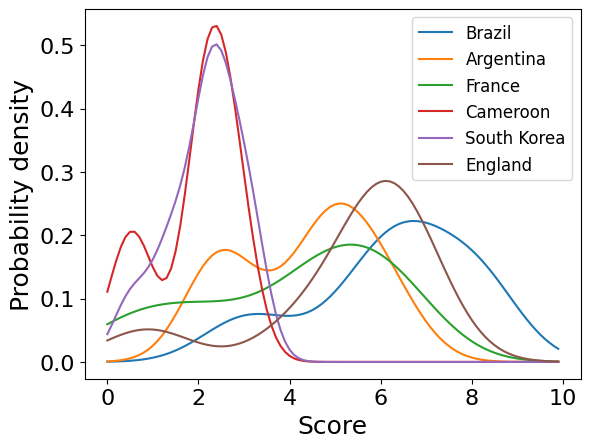

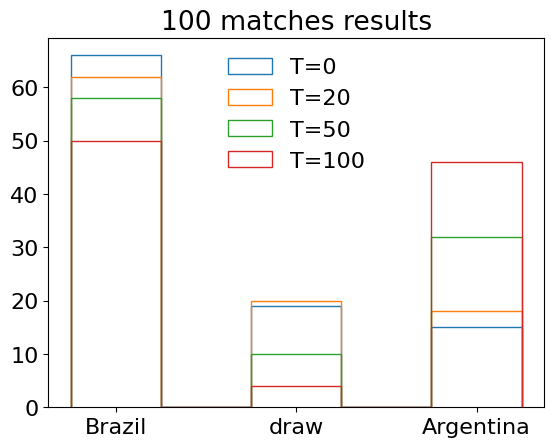

In [70]:
#exemplos de distribuiçoes

sq_list = ["Brazil","Argentina","France","Cameroon","South Korea","England"]
fig, ax = plt.subplots(1,1)

for squad in ["Brazil","Argentina","France","Cameroon","South Korea","England"]:
    dist = stats.gaussian_kde(scores_squad[squad],bw_method=0.5)
    
    x = np.arange(0,10,0.1)
    y = dist.pdf(x)

    ax.plot(x,y,label=squad)
    ax.set_ylabel("Probability density",size=18)
    ax.set_xlabel("Score",size=18)
    ax.legend(fontsize=12)
    
squad1 = "Brazil"
squad2 = "Argentina"
n_matches = 100
dist = stats.gaussian_kde(scores_squad[squad1],bw_method=0.5)
dist_adv = stats.gaussian_kde(scores_squad[squad2],bw_method=0.5)

fig1, ax1 = plt.subplots(1,1)
for T in [0,20,50,100]:
    count = []
    for i in range(n_matches):
        match_result = world_cup.simulate_match(dist, dist_adv, squad1, squad2, T)
        count.append(match_result)

    #resultado de 100 confrontos
    counts = list(map({squad1:1,"draw":3,squad2:5}.get,count))
    n, bins, patches = ax1.hist(counts, bins=5, label=f"T={T}", histtype="step")
    dx = bins[1] - bins[0]
    ax1.set_xticks([bins[0]+0.5*dx, bins[2]+0.5*dx, bins[4]+0.5*dx])
    ax1.set_xticklabels([squad1, "draw", squad2])
    ax1.legend(frameon=False)
    ax1.set_title(f"100 matches results")


# Simulating the group stage of a World Cup

The method simulate_group_stage() simulates the group stage matches.

In [71]:
groups = {"A":["Qatar","Ecuador","Senegal","Netherlands"],"B":["England","Iran","USA","Wales"],"C":["Argentina","Saudi Arabia","Mexico","Poland"],"D":["France","Australia","Denmark","Tunisia"],"E":["Spain","Costa Rica","Germany","Japan"],"F":["Belgium","Canada","Morocco","Croatia"],"G":["Brazil","Serbia","Switzerland","Cameroon"],"H":["Portugal","Ghana","Uruguay","South Korea"]}

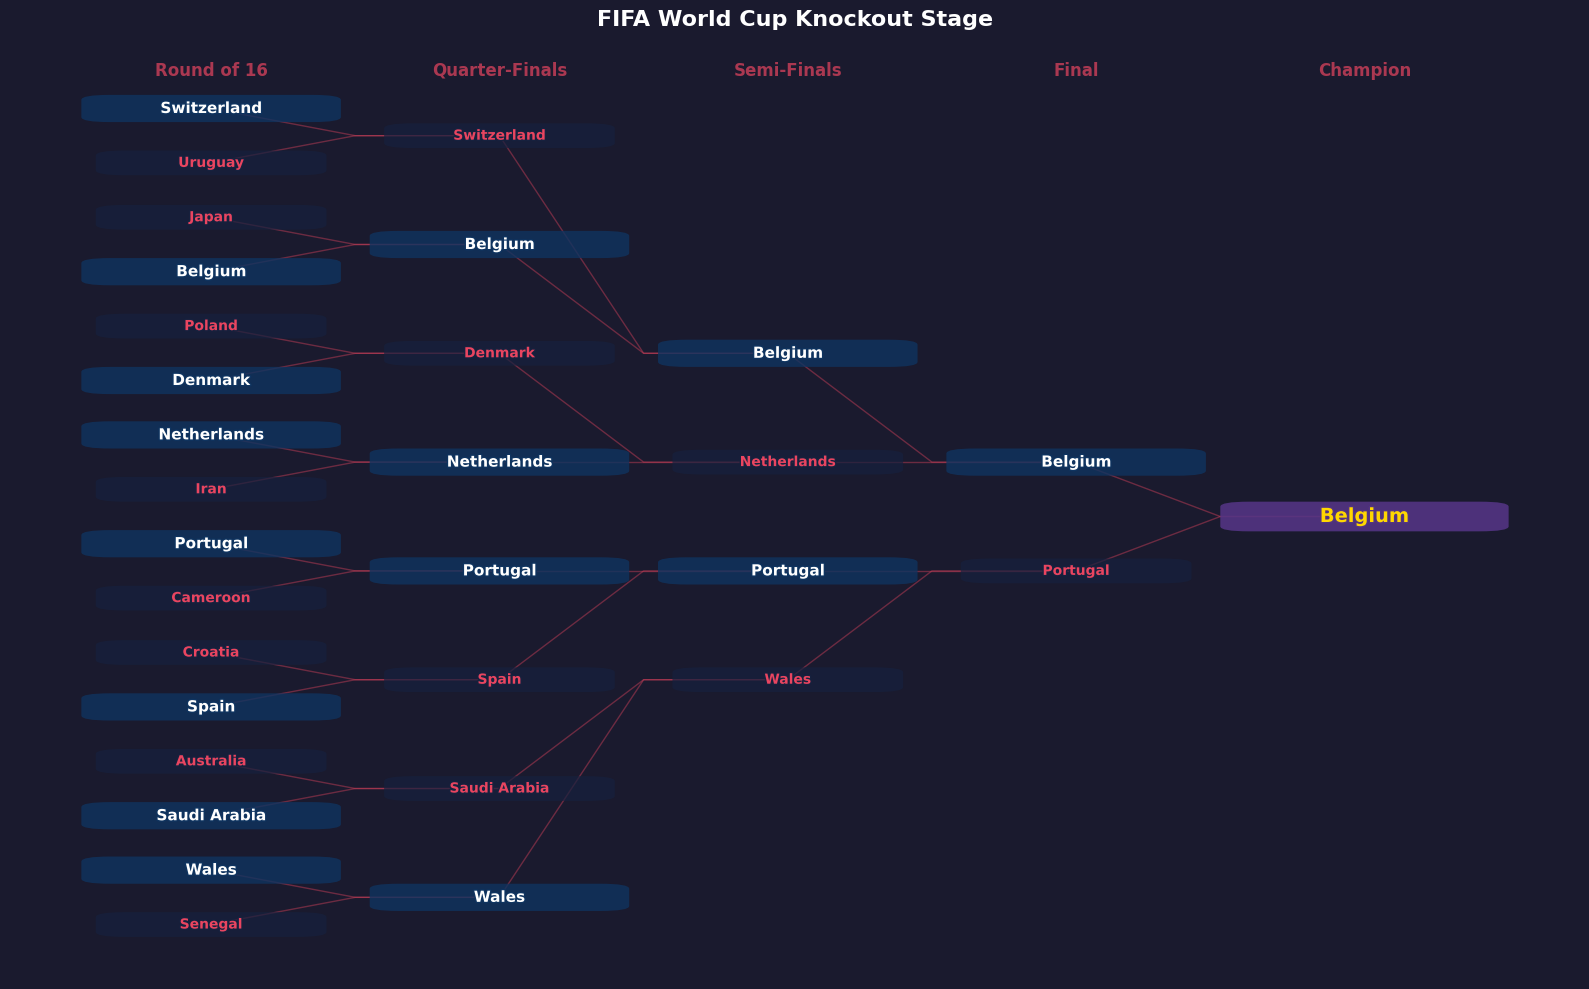

In [87]:
WorldCup = world_cup(groups, squad_distribution, temperature=50)
WorldCup.groups

group_stage_results, points = WorldCup.simulate_group_stage()
results_df = pd.DataFrame(group_stage_results)

# Simulate knockout stage
champion, all_pairs, all_winners = WorldCup.simulate_knockout_stage(points)

100%|██████████| 200/200 [00:06<00:00, 31.98it/s]
/var/folders/13/b14w66xd7plcv19ylpmhl54w0000gn/T/ipykernel_48995/2828212997.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
/var/folders/13/b14w66xd7plcv19ylpmhl54w0000gn/T/ipykernel_48995/2828212997.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


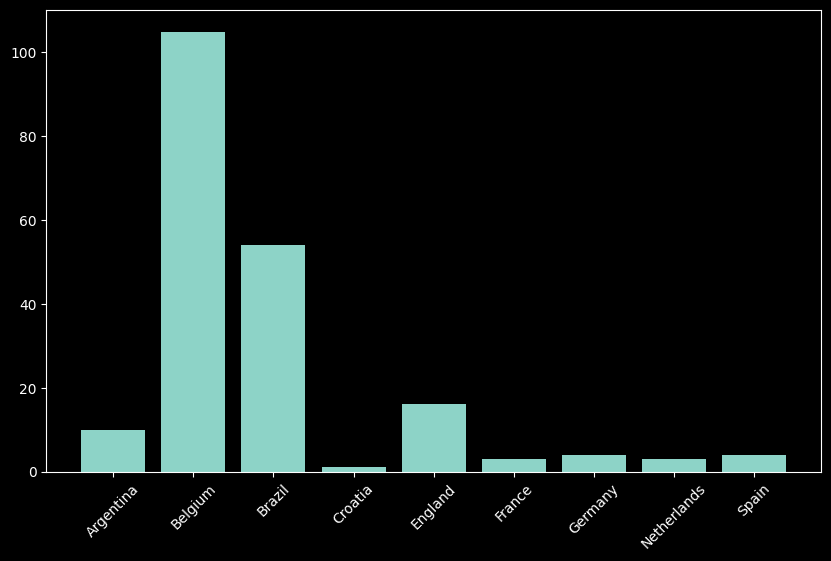

In [109]:
from tqdm import tqdm

T = 100
num_of_wcs = 200
champions = []

for i in tqdm(range(num_of_wcs)):
    WorldCup = world_cup(groups, squad_distribution, temperature=T)
    WorldCup.groups

    group_stage_results, points = WorldCup.simulate_group_stage()
    results_df = pd.DataFrame(group_stage_results)

    # Simulate knockout stage
    champion, all_pairs, all_winners = WorldCup.simulate_knockout_stage(points, plot=False)
    champions.append(champion)

champion_counts = {team: champions.count(team) for team in set(champions)}

fig, ax = plt.subplots(figsize=(10, 6))
labels = sorted(champion_counts.keys())
values = [champion_counts[label] for label in labels]

ax.bar(labels, values, label=f"T={T}")
ax.set_xticklabels(labels, rotation=45)
ax.set_xticks(np.arange(len(labels)))
fig.show()
